In [1]:
# Import packages
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import pandas as pd
import anndata as ad
import re

scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=100, frameon=False)
cr.settings.verbosity = 4
# Read in the single cell data
adata = sc.read_h5ad('merged_challenge.h5ad')

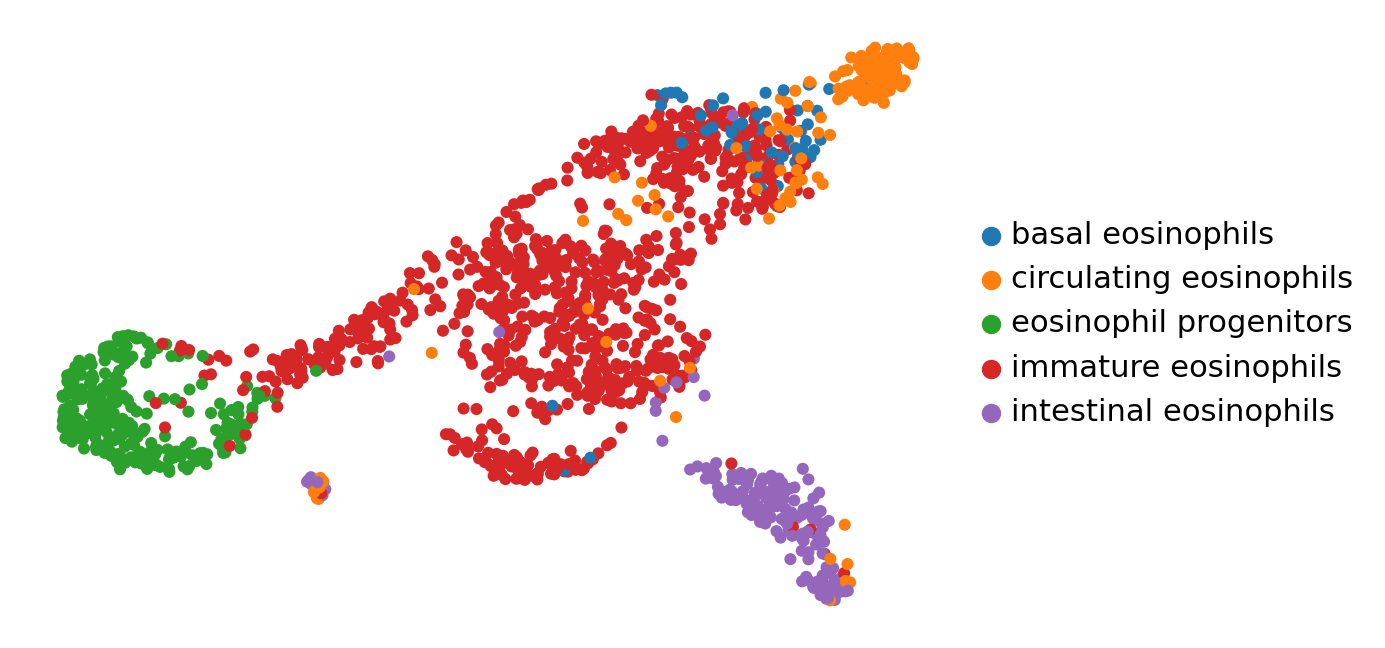

In [2]:
sc.pl.umap(adata, color='Subset', frameon=False, title='')

In [3]:
# Rename the clusters for consistency in the text
adata.obs['Subset'] = [re.sub("intestinal","active",elem) for elem in adata.obs['Subset']]
adata.obs['Subset'] = [re.sub("progenitors","precursors",elem) for elem in adata.obs['Subset']]


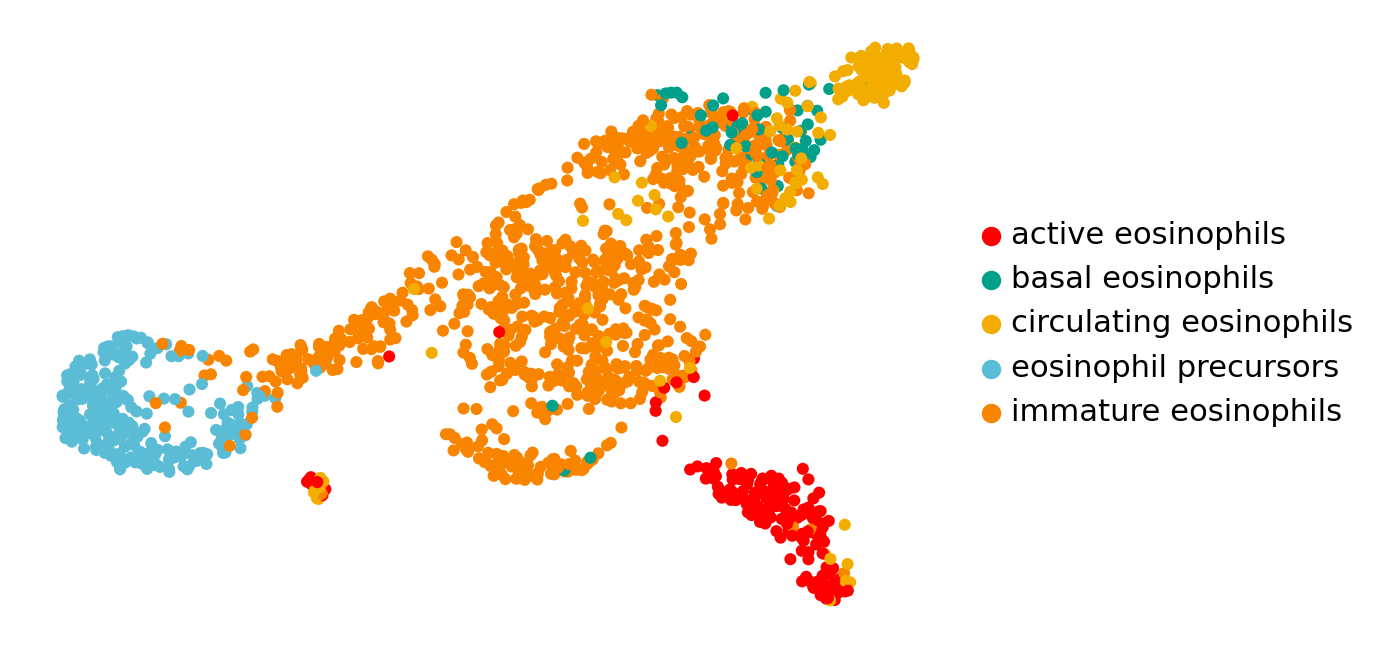

In [4]:
# Choosing the same colors from the R analysis
adata.uns['Subset_colors'] = ['#FF0000','#00A08A','#F2AD00','#5BBCD6','#F98400']
sc.pl.umap(adata, color='Subset', frameon=False, title='')

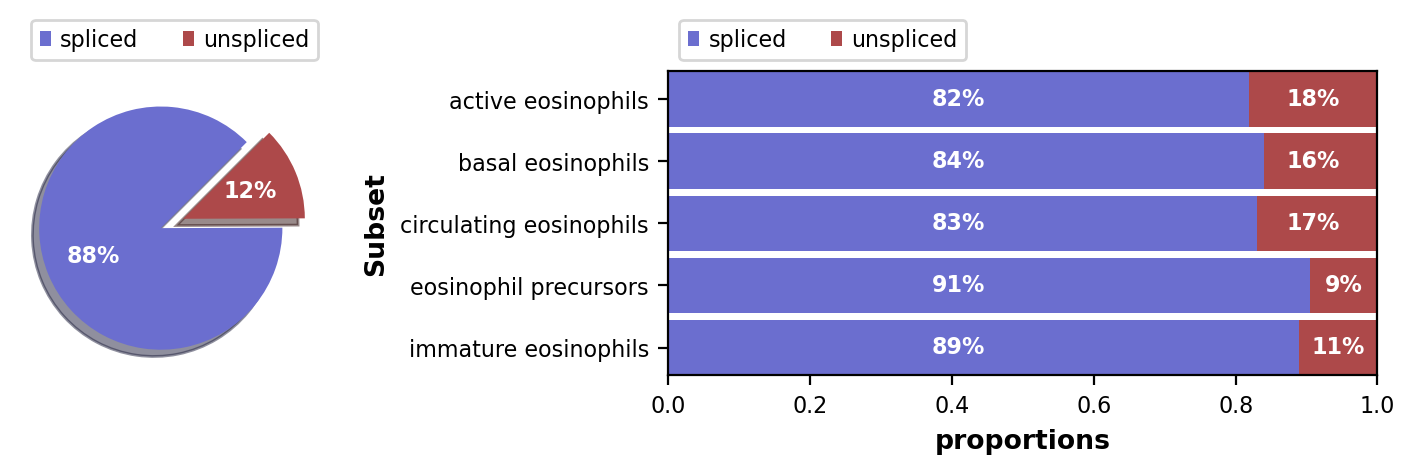

In [5]:
# Checking proportions
scv.pl.proportions(adata, groupby="Subset")

In [7]:
# Since we have only bonemarrow, blood and colon in the challenge data, we do not subset here
# organ=["bonemarrowCR", "bloodCR", "colonCR"]
organ_save=["b_b_c"]

In [9]:
# Starting with clustering
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 38285 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


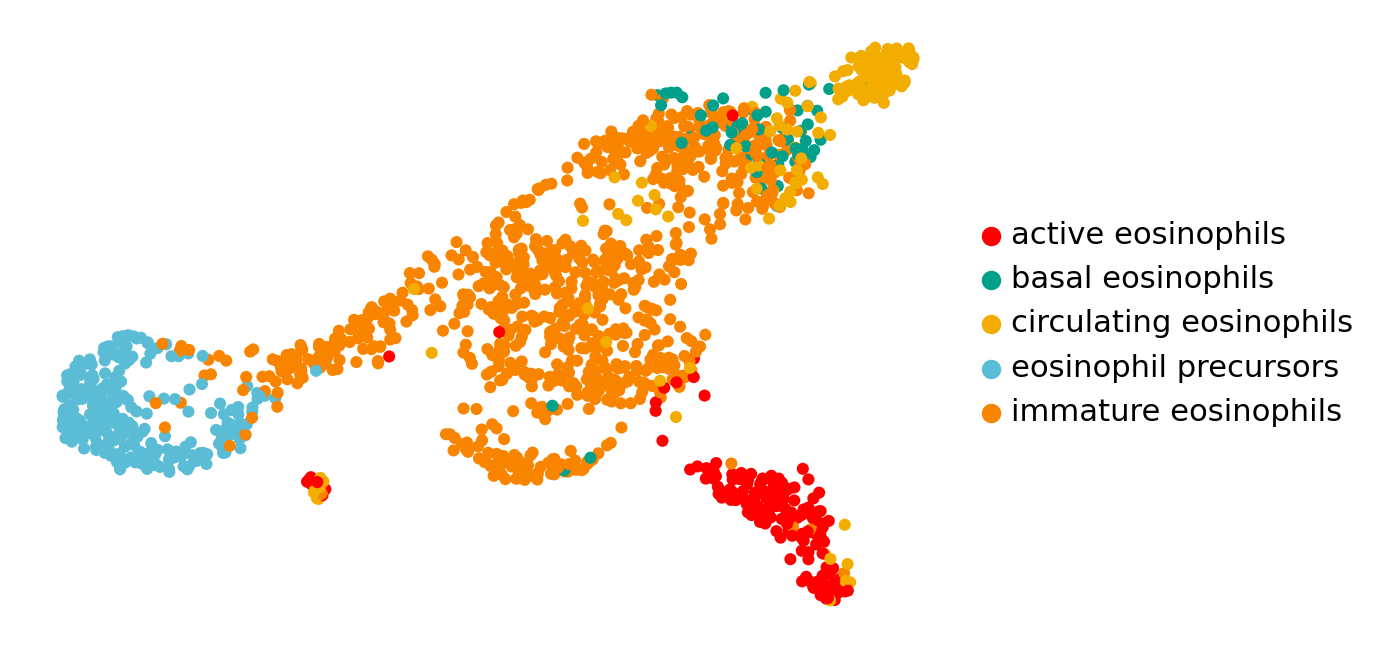

In [12]:
sc.pl.umap(adata, color='Subset', frameon=False, title='', save=f"ch_{organ_save[0]}_umap")

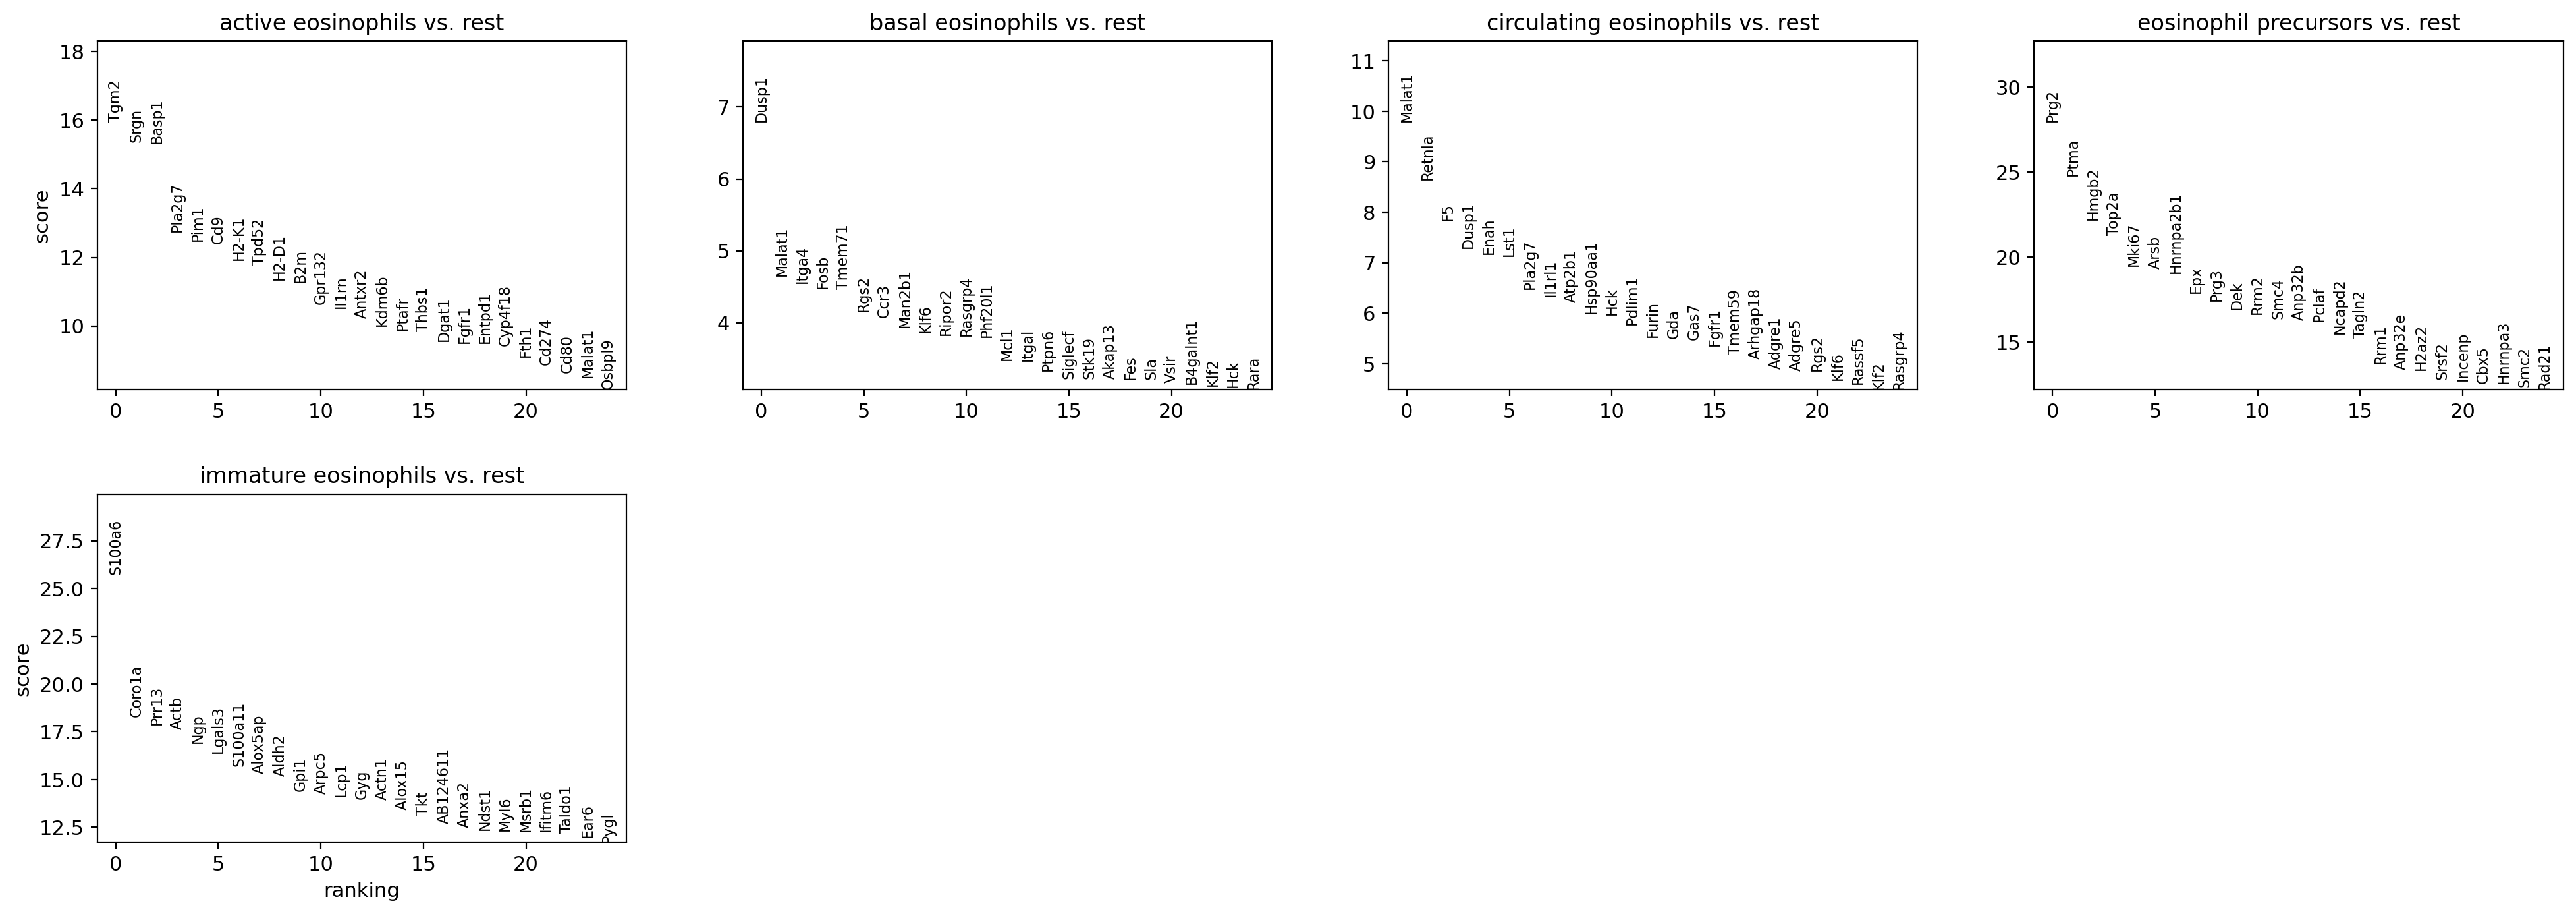

In [13]:
# We confirm the genes that show the highest difference for each group of eosinophils 
sc.tl.rank_genes_groups(adata, 'Subset', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save=f"ch_{organ_save[0]}_geneRanks")

In [27]:
# We choose dynamical model for the velocity and monte carlo for the cell fate determination
chosen_mode='dynamical'
fate_mode='monte_carlo'

In [28]:
# Calculate velocity
scv.tl.velocity(adata, mode=chosen_mode)
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/144 cores)


/home/ilacar/miniconda3/envs/cellrank-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple MacOS to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ---------

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_ch_b_b_c_dynamical_velocity.svg


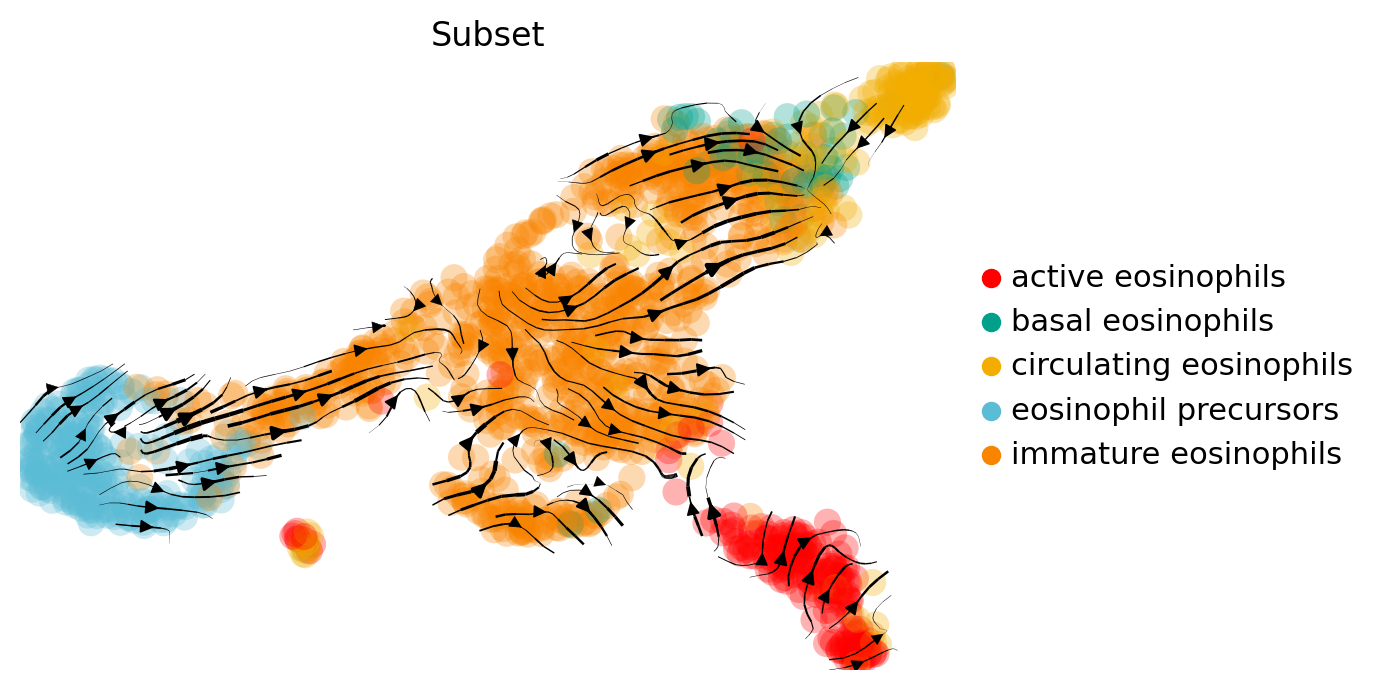

In [29]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color='Subset', legend_loc="right margin", save=f'ch_{organ_save[0]}_{chosen_mode}_velocity.svg')

In [20]:
# Predict terminal states
cr.tl.terminal_states(adata, cluster_key="Subset", weight_connectivities=0.2, mode=fate_mode, n_jobs = 8, force_recompute=True)

DEBUG: Checking the KNN graph for symmetry
DEBUG: KNN graph is symmetric (0:00:00)
Defaulting to `mode='monte_carlo'` and `n_samples=1000`
Computing transition matrix based on logits using `'monte_carlo'` mode
Estimating `softmax_scale` using `'deterministic'` mode


/tmp/ipykernel_119741/2687023517.py:1: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.terminal_states(adata, cluster_key="Subset", weight_connectivities=0.2, mode=fate_mode, n_jobs = 8, force_recompute=True)
/home/ilacar/miniconda3/envs/cellrank-env/lib/python3.9/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [00:21<00:00, 74.97cell/s]


Setting `softmax_scale=9.7311`


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [00:07<00:00, 200.45sample/s]


    Finish (0:00:29)
Using a connectivity kernel with weight `0.2`
DEBUG: Checking the KNN graph for symmetry
DEBUG: KNN graph is symmetric (0:00:00)
Computing transition matrix based on `adata.obsp['connectivities']`
DEBUG: Density-normalizing the transition matrix
    Finish (0:00:00)
DEBUG: Using cached transition matrix
DEBUG: Using cached transition matrix
DEBUG: Using cached transition matrix
DEBUG: Using cached transition matrix
Computing eigendecomposition of the transition matrix
DEBUG: Computing top `20` eigenvalues of a sparse matrix
DEBUG: Sorting eigenvalues by their real part
Adding `adata.uns['eigendecomposition_fwd']`
       `.eigendecomposition`
    Finish (0:00:00)
Computing Schur decomposition
Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000029e+00 4.1451820497816127e-03 
0.0000000000000000e+00 9.9212429657890111e-01 
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:0

saving figure to file ./figures/scvelo_ch_b_b_c_stochastic_terminal.pdf


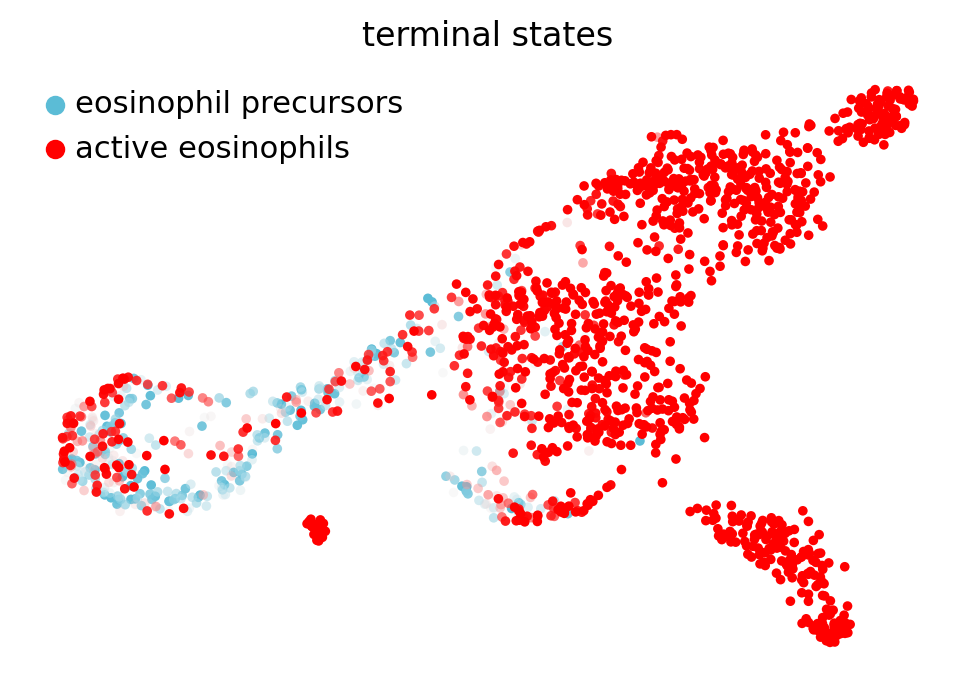

In [21]:
cr.pl.terminal_states(adata, color='Subset', legend_loc = "best", same_plot=True, discrete= False, save=f'ch_{organ_save[0]}_{fate_mode}_terminal')

DEBUG: Checking the KNN graph for symmetry
DEBUG: KNN graph is symmetric (0:00:00)
Computing transition matrix based on logits using `'deterministic'` mode
Estimating `softmax_scale` using `'deterministic'` mode


/tmp/ipykernel_119741/2129173123.py:1: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.initial_states(adata, cluster_key="Subset", mode=fate_mode, force_recompute=True)
/home/ilacar/miniconda3/envs/cellrank-env/lib/python3.9/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [00:00<00:00, 3742.32cell/s]
[0]PETSC ERROR: -----------------------------

Setting `softmax_scale=9.7311`


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1583/1583 [00:00<00:00, 3637.54cell/s]
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple MacOS to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    Finish (0:00:02)
Using a connectivity kernel with weight `0.2`
DEBUG: Checking the KNN graph for symmetry
DEBUG: KNN graph is symmetric (0:00:00)
Computing transition matrix based on `adata.obsp['connectivities']`
DEBUG: Density-normalizing the transition matrix
    Finish (0:00:00)
DEBUG: Using cached transition matrix
DEBUG: Using cached transition matrix
DEBUG: Using cached transition matrix
DEBUG: Using cached transition matrix
Computing eigendecomposition of the transition matrix
DEBUG: Computing top `20` eigenvalues of a sparse matrix
DEBUG: Sorting eigenvalues by their real part
Adding `adata.uns['eigendecomposition_bwd']`
       `.eigendecomposition`
    Finish (0:00:00)
Computing Schur decomposition
Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000007e+00 -1.6824557604601712e-03 -5.4005604589358756e-04 -3.5319926349305933e-02 2.0828130297507765e-02 
0.0000000000000000e+00 9.9735538327405493e-01 -4.3773935248441458e-03 -1.6849832560805678e-02 2.0359800346271412e-

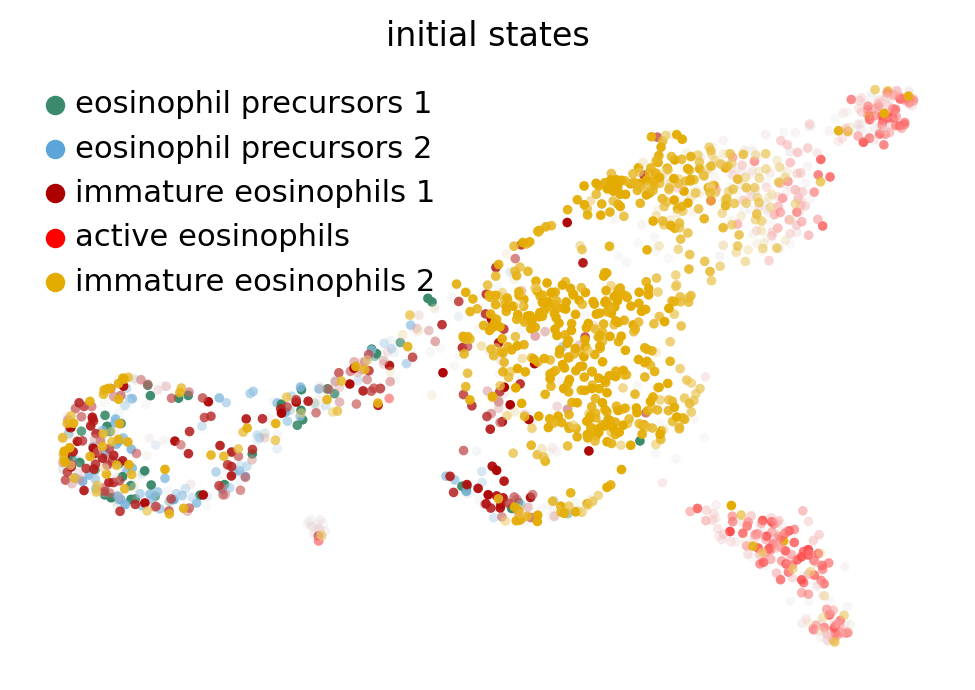

In [22]:
# Predict initial states
cr.tl.initial_states(adata, cluster_key="Subset", mode=fate_mode, force_recompute=True)
cr.pl.initial_states(adata, discrete=False, same_plot=True, color='Subset', legend_loc = "best", save=f'ch_{organ_save[0]}_{fate_mode}_initial')

In [23]:
# Now we go on with the PAGA analysis
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.recover_latent_time(
    adata, root_key="initial_states_probs", end_key="terminal_states_probs"
)

recovering dynamics (using 8/144 cores)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple MacOS to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple MacOS to find memory corruption errors

    finished (0:00:04) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing latent time using initial_states_probs, terminal_states_probs as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


In [24]:
scv.tl.paga(
    adata,
    groups="Subset",
    root_key="initial_states_probs",
    end_key="terminal_states_probs",
    use_time_prior="velocity_pseudotime",
)

running PAGA using priors: ['velocity_pseudotime', 'initial_states_probs', 'terminal_states_probs']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


In [25]:
cr.tl.lineages(adata)

Computing absorption probabilities
DEBUG: Solving the linear system using `PETSc` solver `'gmres'` on `1` core(s) with no preconditioner and `tol=1e-06`


/tmp/ipykernel_119741/4866057.py:1: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineages(adata)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 36.92/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)



[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple MacOS to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


DEBUG: Plotting in mode `'paga_pie'`


/home/ilacar/miniconda3/envs/cellrank-env/lib/python3.9/site-packages/networkx/convert.py:158: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)


DEBUG: Saving figure to `'figures/ch_b_b_c_stochastic_PAGA.pdf'`


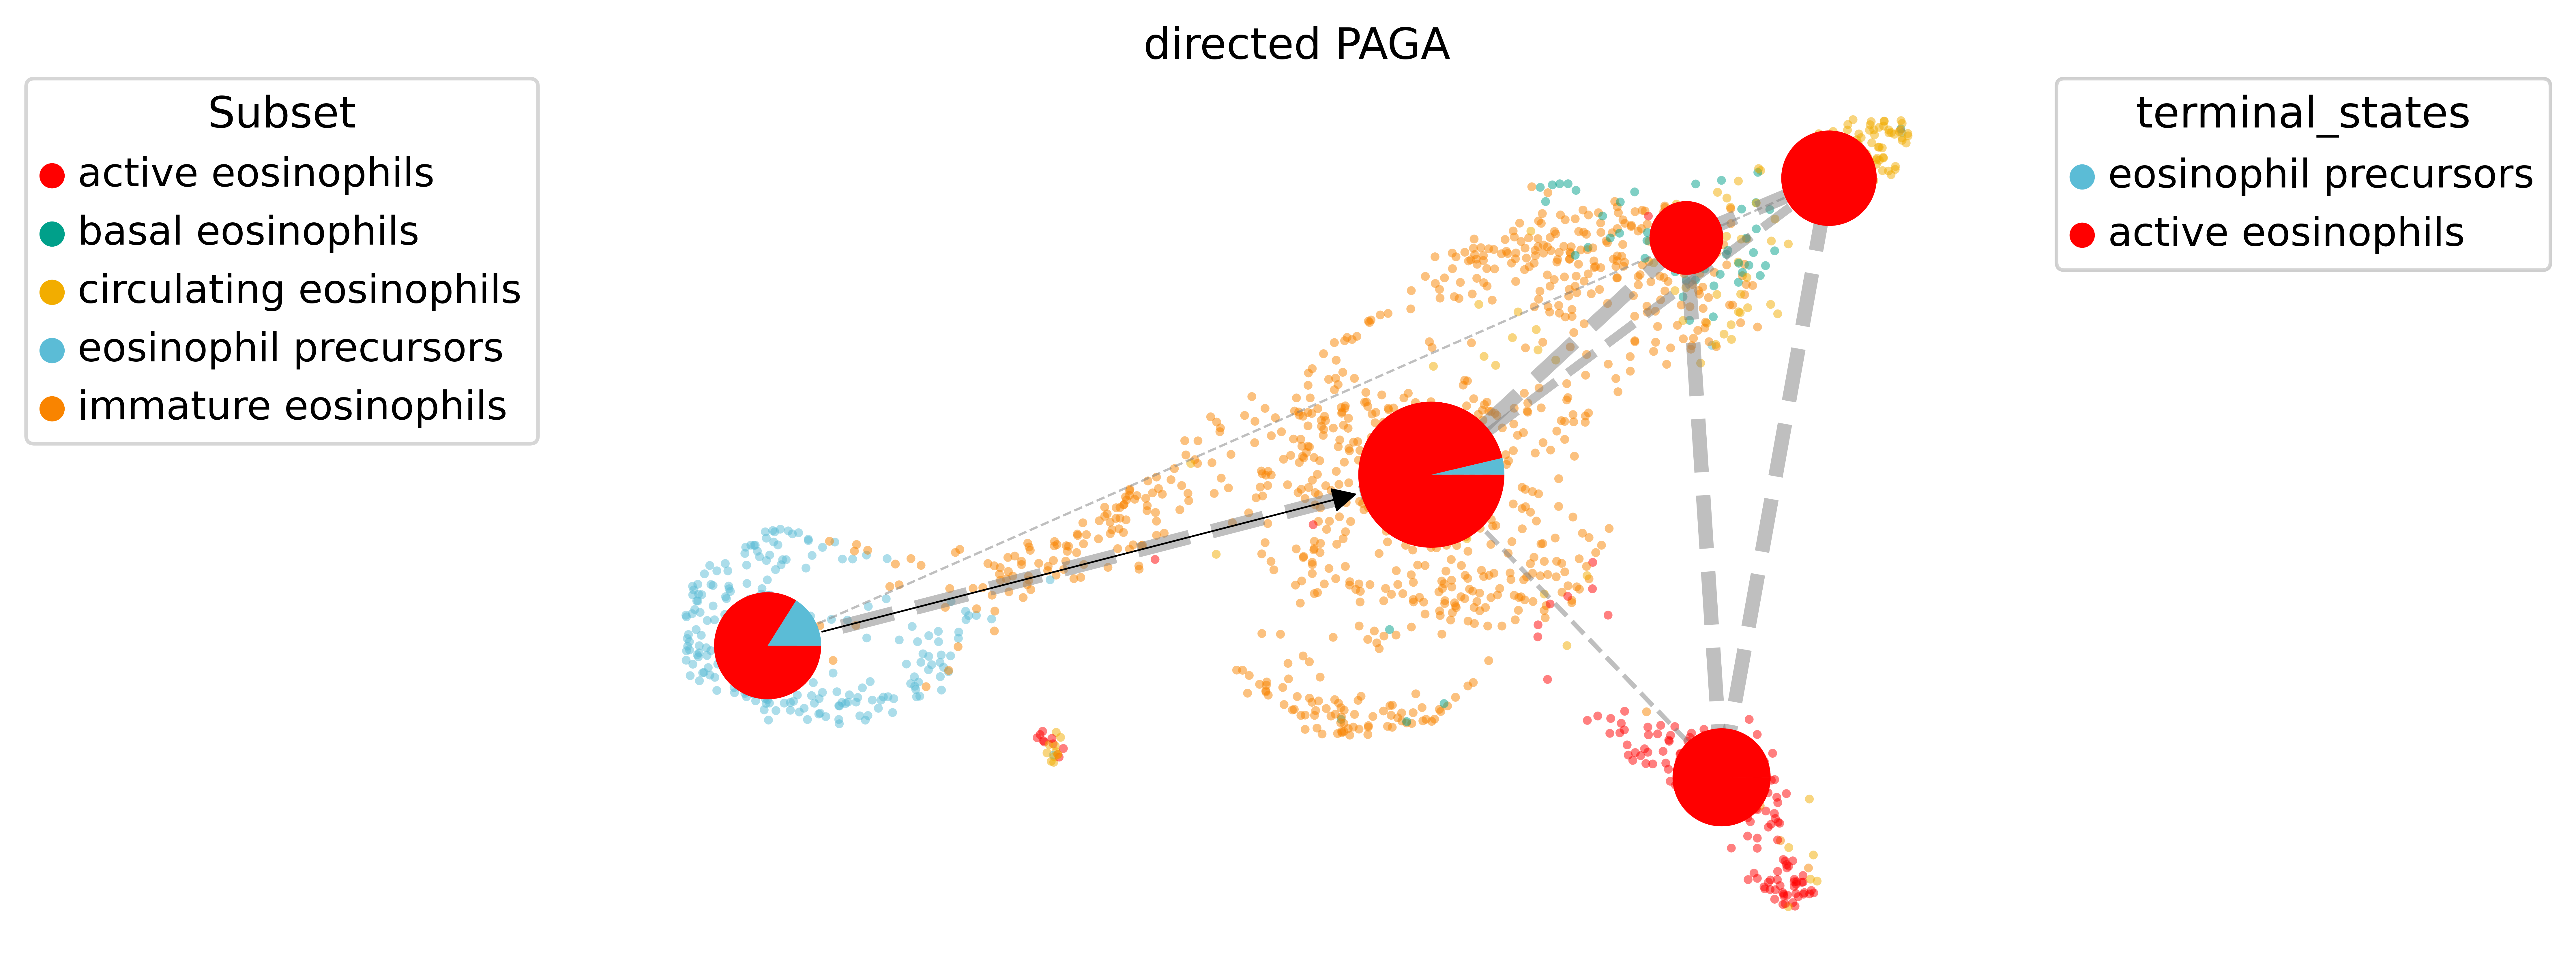

In [26]:
cr.pl.cluster_fates(
    adata,
    mode="paga_pie",
    cluster_key="Subset",
    basis="umap",
    legend_kwargs={"loc": "top right out"},
    legend_loc="top left out",
    node_size_scale=5,
    edge_width_scale=1,
    max_edge_width=4,
    title="directed PAGA",
    save=f'ch_{organ_save[0]}_{fate_mode}_PAGA.pdf',
    dpi=450
)